In [1]:
import igraph as ig

G = ig.Graph(directed=True, vertex_attrs={"name": []}, edge_attrs={"edge_type": [], "weight": []})
G

In [2]:
import csv

with open("pag.csv") as f:
  r = csv.reader(f)
  next(r)  # skip first (header) line
  for line in r:
    edge_type = line[12]

    from_epoch, from_ts, from_wid, from_seqno = line[:4]
    from_vertex = ",".join([from_ts, from_wid])

    to_epoch, to_ts, to_wid, to_seqno = line[6:10]
    to_vertex = ",".join([to_ts, to_wid])
    
    if from_vertex not in G.vs["name"]:
      G.add_vertex(name=from_vertex, epoch=int(from_epoch), timestamp=int(from_ts), workerid=from_wid, seqno=from_seqno)
    if to_vertex not in G.vs["name"]:
      G.add_vertex(name=to_vertex, epoch=int(to_epoch), timestamp=int(to_ts), workerid=to_wid, seqno=to_seqno)
    
    G.add_edge(from_vertex, to_vertex, edge_type=edge_type, weight=int(to_ts) - int(from_ts))

In [3]:
len(G.vs), len(G.es)

(5489, 8265)

## Calculating duration for each worker activity or inter-worker message.

In [4]:
edge_types = set()  # using set to capture unique values

for attr in G.es["edge_type"]:
  edge_types.add(attr)

print(f"Edge Types: {edge_types}")

Edge Types: {'Spinning', 'Waiting', 'Processing', 'Busy', 'ControlMessage', 'DataMessage'}


In [5]:
activity_durations = {edge_type: [] for edge_type in edge_types}  # dict of (edge type, list of edge durations)

for e in G.es:
  edge_type, duration = e["edge_type"], e["weight"]
  activity_durations[edge_type].append(duration)

avg_duration = {edge_type: sum(durations) / len(durations) for edge_type, durations in activity_durations.items()}

print(avg_duration)

{'Spinning': 38449.579124579126, 'Waiting': 1972106.1589090908, 'Processing': 1433374.9642248722, 'Busy': 53500.76689189189, 'ControlMessage': -27660997.63448021, 'DataMessage': 357477283.4266667}


Text(0.5, 1.0, 'Average Duration of Activities/Messages')

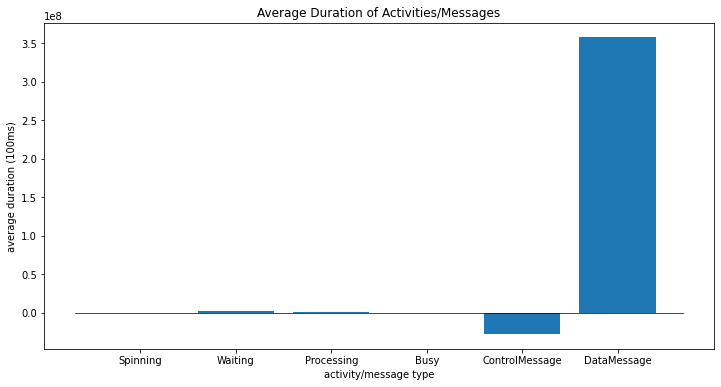

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot()
ax1.bar(list(edge_types), avg_duration.values())
ax1.plot(plt.xlim(), [0, 0], "k-", linewidth=0.7)

plt.xlabel("activity/message type")
plt.ylabel("average duration (100ms)")
plt.title("Average Duration of Activities/Messages")

For some reason, the ControlMessage activity seems to have a negative average duration.

### Investigating the negative value for ControlMessage

Text(0.5, 0.98, 'Understanding Negative Score for Avg. ControlMessage Duration')

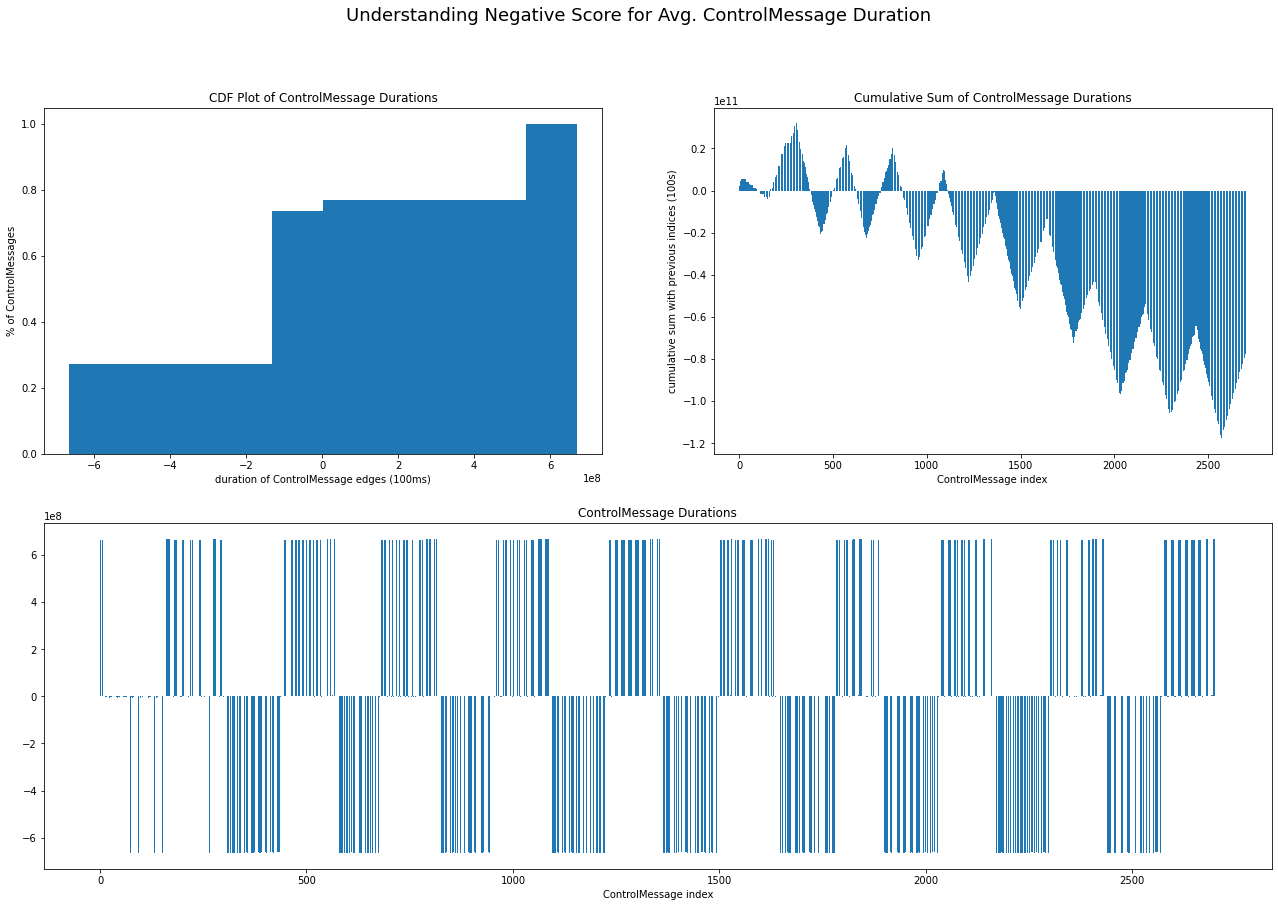

In [7]:
## Cumulative Sum plot for ControlMessage

import numpy as np

cm_durations = activity_durations["ControlMessage"]
num_cm = len(cm_durations)
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(cm_durations, cumulative=True, density=1)
ax1.set_xlabel("duration of ControlMessage edges (100ms)")
ax1.set_ylabel("% of ControlMessages")
ax1.set_title("CDF Plot of ControlMessage Durations")

ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(range(num_cm), np.cumsum(cm_durations))
ax2.set_xlabel("ControlMessage index")
ax2.set_ylabel("cumulative sum with previous indices (100s)")
ax2.set_title("Cumulative Sum of ControlMessage Durations")

ax3 = fig.add_subplot(gs[1, :])
ax3.bar(range(num_cm), cm_durations)
ax3.set_xlabel("ControlMessage index")
ax3.set_ylabel("")
ax3.set_title("ControlMessage Durations")

fig.suptitle("Understanding Negative Score for Avg. ControlMessage Duration", fontsize=18)

## Degree Distributions

In [8]:
indegree_distribution = np.array([(indegree, count) for (indegree, _, count) in G.degree_distribution(mode="IN").bins()], dtype="int32")
outdegree_distribution = np.array([(outdegree, count) for (outdegree, _, count) in G.degree_distribution(mode="OUT").bins()], dtype="int32")

print(indegree_distribution)
print(outdegree_distribution)

[[   0  135]
 [   1 2574]
 [   2 2697]
 [   3   35]
 [   4   48]]
[[   0  160]
 [   1 4911]
 [   2  233]
 [   3    0]
 [   4    0]
 [   5    0]
 [   6    0]
 [   7    0]
 [   8    0]
 [   9    0]
 [  10    0]
 [  11    1]
 [  12   16]
 [  13    0]
 [  14    1]
 [  15    1]
 [  16  166]]


### In-Degree Distribution

Text(0.5, 1.0, 'In-Degree Distribution Histogram')

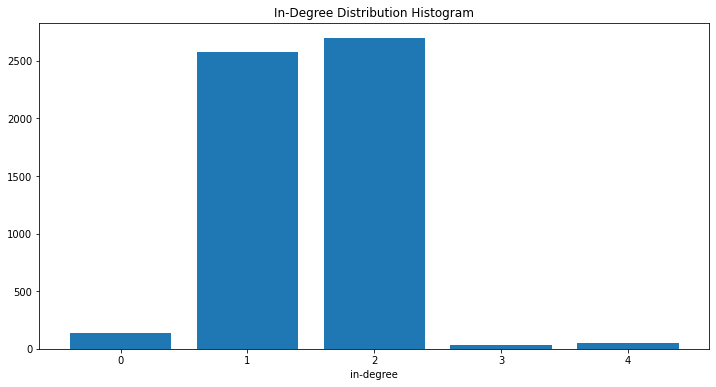

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(indegree_distribution[:,0], indegree_distribution[:,1])
plt.xlabel("in-degree")
plt.title("In-Degree Distribution Histogram")

### Out-Degree Distribution

Text(0.5, 1.0, 'Out-Degree Distribution Histogram')

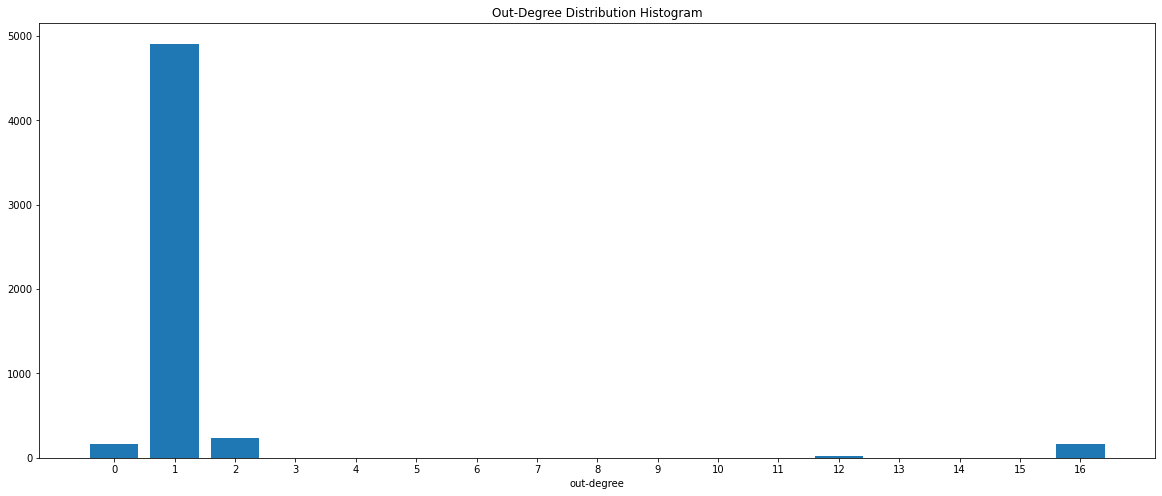

In [10]:
plt.figure(figsize=(20, 8))
plt.bar(outdegree_distribution[:,0], outdegree_distribution[:,1], tick_label=outdegree_distribution[:,0])
plt.xlabel("out-degree")
plt.title("Out-Degree Distribution Histogram")

## Centrality Measures

### Degree Centrality

Text(0.5, 1.0, 'CDF Plot of Degree Centralities')

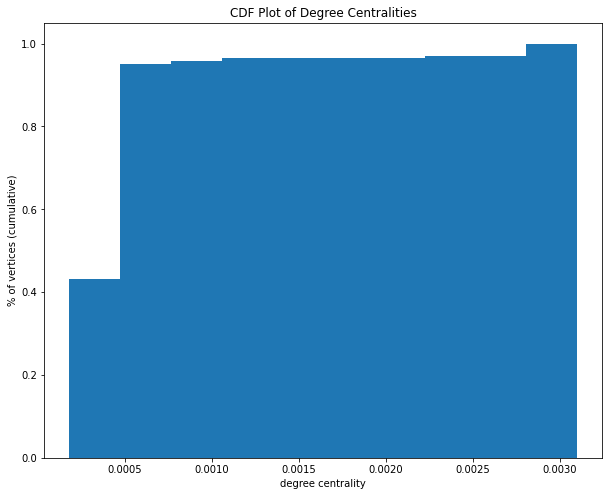

In [11]:
degree_centrality = np.array(G.degree()) / (len(G.vs) - 1)

plt.figure(figsize=(10, 8))
plt.hist(degree_centrality, cumulative=True, density=1)
plt.xlabel("degree centrality")
plt.ylabel("% of vertices (cumulative)")
plt.title("CDF Plot of Degree Centralities")

#### InDegree and OutDegree

Text(0.5, 1.0, 'CDF Plot of OutDegree Centralities')

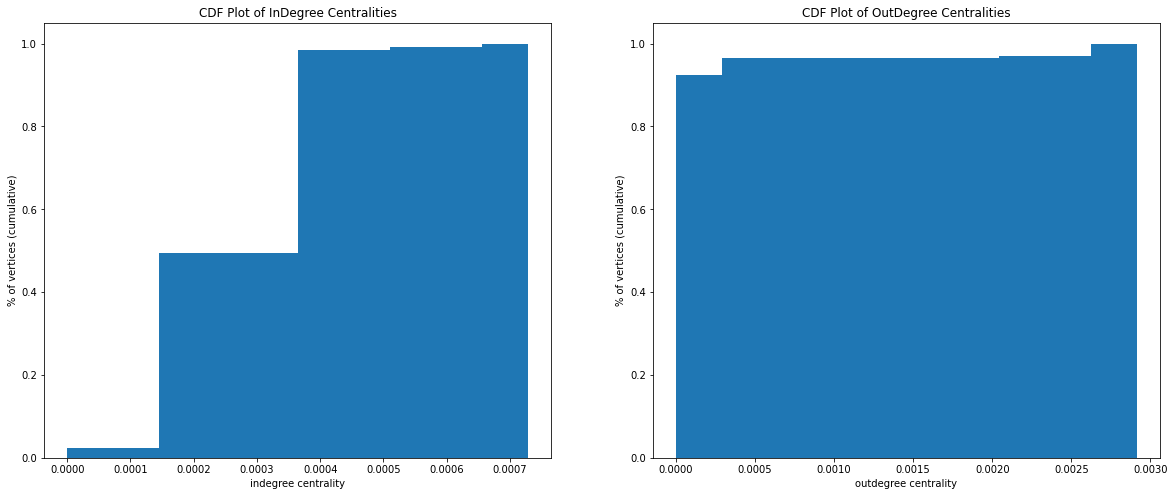

In [12]:
indegree_centrality = np.array(G.degree(mode="IN")) / (len(G.vs) - 1)
outdegree_centrality = np.array(G.degree(mode="OUT")) / (len(G.vs) - 1)

fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(121)
ax1.hist(indegree_centrality, cumulative=True, density=1)
ax1.set_xlabel("indegree centrality")
ax1.set_ylabel("% of vertices (cumulative)")
ax1.set_title("CDF Plot of InDegree Centralities")

ax2 = fig.add_subplot(122)
ax2.hist(outdegree_centrality, cumulative=True, density=1)
ax2.set_xlabel("outdegree centrality")
ax2.set_ylabel("% of vertices (cumulative)")
ax2.set_title("CDF Plot of OutDegree Centralities")

### Closeness Centrality  

In [13]:
## Since some negative edges are being produced due to clock skew,
## for now we will just consider them as 0 time duration
#
# H = G.copy()
# for e in H.es:
#   if e["weight"] < 0:
#     e["weight"] = 0

In [14]:
# def closeness(v):
#   paths = np.array(H.get_all_shortest_paths(v, weights="weight", mode="IN"))
  

### Load Centrality

## Graph similarity (compared with artificial bottlenecks)